In [ ]:
!pip install medmnist
!python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256

In [ ]:
!pip install torch torchvision torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 48.4 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y torch-fidelity torchmetrics
!pip install torchmetrics[image] torch-fidelity

Found existing installation: torchmetrics 1.7.0
Uninstalling torchmetrics-1.7.0:
  Successfully uninstalled torchmetrics-1.7.0
  Using cached torchmetrics-1.7.0-py3-none-any.whl.metadata (21 kB)
Using cached torchmetrics-1.7.0-py3-none-any.whl (960 kB)


LS GAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from medmnist import PathMNIST
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load MedMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Normalize((0.5,), (0.5,))
])
dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, 128 * 7 * 7)
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    def forward(self, z):
        x = self.fc(z).view(-1, 128, 7, 7)
        return self.conv_blocks(x)

In [ ]:
# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc = nn.Linear(128 * 7 * 7, 1)
    def forward(self, img):
        x = self.conv_blocks(img).view(img.size(0), -1)
        return self.fc(x)

In [ ]:
# Initialize models
generator = Generator(z_dim=100).to(device)
discriminator = Discriminator().to(device)

# Define optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function (LS-GAN)
criterion = nn.MSELoss()

In [ ]:

# Training Loop for LS-GAN
num_epochs = 50
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)
        noise = torch.randn(batch_size, 100, device=device)
        fake_imgs = generator(noise)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_out = discriminator(real_imgs)
        fake_out = discriminator(fake_imgs.detach())
        loss_D = criterion(real_out, torch.ones_like(real_out)) + criterion(fake_out, torch.zeros_like(fake_out))
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_out = discriminator(fake_imgs)
        loss_G = criterion(fake_out, torch.ones_like(fake_out))
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

Epoch [1/50] | Loss D: 0.0355 | Loss G: 1.3348
Epoch [2/50] | Loss D: 0.0624 | Loss G: 1.2270
Epoch [3/50] | Loss D: 0.0274 | Loss G: 0.9742
Epoch [4/50] | Loss D: 0.0367 | Loss G: 1.1251
Epoch [5/50] | Loss D: 0.0660 | Loss G: 1.2392
Epoch [6/50] | Loss D: 0.0397 | Loss G: 0.8404
Epoch [7/50] | Loss D: 0.0246 | Loss G: 1.1141
Epoch [8/50] | Loss D: 0.0231 | Loss G: 0.9446
Epoch [9/50] | Loss D: 0.0311 | Loss G: 1.1138
Epoch [10/50] | Loss D: 0.1348 | Loss G: 0.4910
Epoch [11/50] | Loss D: 0.1376 | Loss G: 0.5440
Epoch [12/50] | Loss D: 0.0143 | Loss G: 1.0496
Epoch [13/50] | Loss D: 0.0761 | Loss G: 0.7774
Epoch [14/50] | Loss D: 0.0163 | Loss G: 0.9604
Epoch [15/50] | Loss D: 0.0905 | Loss G: 1.7110
Epoch [16/50] | Loss D: 0.0112 | Loss G: 1.0045
Epoch [17/50] | Loss D: 0.0164 | Loss G: 1.0752
Epoch [18/50] | Loss D: 0.0427 | Loss G: 1.2720
Epoch [19/50] | Loss D: 0.0247 | Loss G: 1.0386
Epoch [20/50] | Loss D: 0.0186 | Loss G: 0.8942
Epoch [21/50] | Loss D: 0.1111 | Loss G: 1.6060
E

In [ ]:
def evaluate_lsgan(generator, z_dim, num_samples=100):
    generator.eval()
    fake_images = []

    with torch.no_grad():
        for _ in range(num_samples // 64):
            noise = torch.randn(64, z_dim, device=device)
            generated_batch = generator(noise).cpu()  # Move to CPU
            generated_batch = ((generated_batch + 1) * 127.5).clamp(0, 255).byte()  # Convert to uint8

            # Convert 1-channel grayscale to 3-channel RGB for Inception Model
            generated_batch = generated_batch.repeat(1, 3, 1, 1)

            fake_images.append(generated_batch)

    fake_images = torch.cat(fake_images, dim=0)

    # Inception Score
    is_metric = InceptionScore()
    is_score = is_metric(fake_images)

    # FID Score
    fid_metric = FrechetInceptionDistance(normalize=True)

    # Get real images from MedMNIST
    real_images, _ = next(iter(train_loader))  # Use train_loader instead of dataloader
    real_images = real_images[:num_samples].cpu()  # Move to CPU
    real_images = ((real_images + 1) * 127.5).clamp(0, 255).byte()  # Convert to uint8

    # Convert real images to 3-channel RGB
    real_images = real_images.repeat(1, 3, 1, 1)

    # Compute FID
    fid_metric.update(real_images, real=True)
    fid_metric.update(fake_images, real=False)
    fid_value = fid_metric.compute()

    print(f"Inception Score (IS): {is_score[0].item():.4f} ± {is_score[1].item():.4f}")
    print(f"Fréchet Inception Distance (FID): {fid_value.item():.4f}")

# Run evaluation
evaluate_lsgan(generator, z_dim)

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Inception Score (IS): 1.5637 ± 0.2243
Fréchet Inception Distance (FID): 231.3327


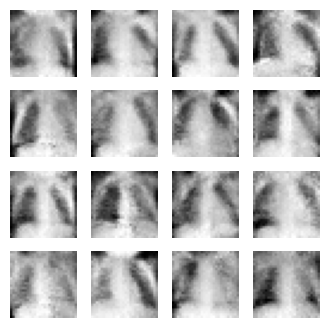

In [ ]:
import matplotlib.pyplot as plt

def save_generated_images(generator, z_dim, num_samples=16):
    generator.eval()
    noise = torch.randn(num_samples, z_dim, device=device)
    fake_images = generator(noise).cpu().detach()
    fake_images = (fake_images + 1) / 2  # Normalize back to [0,1]

    plt.figure(figsize=(4,4))
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        # Selecting the first channel and squeezing to get a 2D array
        plt.imshow(fake_images[i, 0].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

# Generate and save images
save_generated_images(generator, z_dim)

WGAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
import medmnist

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, img_size=28):  # Change img_channels to 1
        super(Generator, self).__init__()
        self.img_channels = img_channels # Assign img_channels as an instance attribute
        self.img_size = img_size # Assign img_size as an instance attribute
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_channels * img_size * img_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), self.img_channels, self.img_size, self.img_size)  # Use self.img_channels and self.img_size
        return img

# Critic (Discriminator) Model
class Critic(nn.Module):
    def __init__(self, img_channels=1, img_size=28):  # Change img_channels to 1
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_channels * img_size * img_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)  # Output a single real/fake score
        )

    def forward(self, img):
        img = img.view(img.size(0), -1)  # Flatten
        return self.model(img)

In [ ]:
z_dim = 100
generator = Generator(z_dim=z_dim).to(device)
critic = Critic().to(device)

optimizer_G = optim.RMSprop(generator.parameters(), lr=5e-5)
optimizer_C = optim.RMSprop(critic.parameters(), lr=5e-5)

# Weight clipping for WGAN
weight_clip = 0.01

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load MedMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Normalize((0.5,), (0.5,))
])
dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
train_loader = dataloader
num_epochs = 50
critic_iterations = 5  # Train Critic more frequently

for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)

        # Train Critic (Discriminator)
        for _ in range(critic_iterations):
            noise = torch.randn(real_imgs.size(0), z_dim, device=device)
            fake_imgs = generator(noise).detach()

            critic_real = critic(real_imgs)
            critic_fake = critic(fake_imgs)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

            # Apply weight clipping
            for p in critic.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        # Train Generator
        noise = torch.randn(real_imgs.size(0), z_dim, device=device)
        fake_imgs = generator(noise)
        loss_G = -torch.mean(critic(fake_imgs))

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss C: {loss_C.item():.4f} | Loss G: {loss_G.item():.4f}")

    # Save generated images
    if (epoch+1) % 10 == 0:
        vutils.save_image(fake_imgs[:25], f"wgan_generated_epoch_{epoch+1}.png", normalize=True)

Epoch [1/50] | Loss C: -0.9472 | Loss G: -0.3251
Epoch [2/50] | Loss C: -1.3649 | Loss G: -0.0707
Epoch [3/50] | Loss C: -1.5475 | Loss G: 1.1188
Epoch [4/50] | Loss C: -0.5884 | Loss G: 0.6587
Epoch [5/50] | Loss C: -1.8693 | Loss G: 0.1928
Epoch [6/50] | Loss C: -4.2924 | Loss G: 1.1676
Epoch [7/50] | Loss C: -2.0203 | Loss G: 1.4448
Epoch [8/50] | Loss C: 0.1995 | Loss G: -4.7322
Epoch [9/50] | Loss C: -1.3006 | Loss G: -2.7585
Epoch [10/50] | Loss C: -0.4873 | Loss G: -1.7592
Epoch [11/50] | Loss C: -0.6148 | Loss G: -0.6742
Epoch [12/50] | Loss C: 0.0293 | Loss G: 0.3892
Epoch [13/50] | Loss C: -0.2425 | Loss G: -0.4296
Epoch [14/50] | Loss C: -1.0814 | Loss G: 0.0577
Epoch [15/50] | Loss C: -2.4117 | Loss G: 0.7378
Epoch [16/50] | Loss C: -0.1220 | Loss G: -1.6112
Epoch [17/50] | Loss C: -0.9995 | Loss G: -0.4119
Epoch [18/50] | Loss C: -1.0568 | Loss G: -0.1013
Epoch [19/50] | Loss C: -0.4907 | Loss G: -2.0199
Epoch [20/50] | Loss C: -0.1104 | Loss G: 0.5249
Epoch [21/50] | Loss

In [ ]:
import torch.nn.functional as F

def evaluate_wgan(generator, z_dim, num_samples=100):
    generator.eval()
    fake_images = []

    with torch.no_grad():
        for _ in range(num_samples // 64):
            noise = torch.randn(64, z_dim, device=device)
            generated_batch = generator(noise).cpu()  # Move to CPU
            generated_batch = ((generated_batch + 1) * 127.5).clamp(0, 255).byte()  # Convert to uint8

            # Convert 1-channel grayscale to 3-channel RGB for Inception Model
            generated_batch = generated_batch.repeat(1, 3, 1, 1)

            fake_images.append(generated_batch)

    fake_images = torch.cat(fake_images, dim=0)

    # Inception Score
    is_metric = InceptionScore()
    is_score = is_metric(fake_images)

    # FID Score
    fid_metric = FrechetInceptionDistance(normalize=True)

    real_images, _ = next(iter(train_loader))
    real_images = real_images[:num_samples].cpu()
    real_images = ((real_images + 1) * 127.5).clamp(0, 255).byte()

    # Convert real images to 3-channel RGB
    real_images = real_images.repeat(1, 3, 1, 1)

    fid_metric.update(real_images, real=True)
    fid_metric.update(fake_images, real=False)
    fid_value = fid_metric.compute()

    print(f"Inception Score (IS): {is_score[0].item():.4f} ± {is_score[1].item():.4f}")
    print(f"Fréchet Inception Distance (FID): {fid_value.item():.4f}")

# Run evaluation
evaluate_wgan(generator, z_dim)

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Inception Score (IS): 1.5339 ± 0.2179
Fréchet Inception Distance (FID): 285.1017


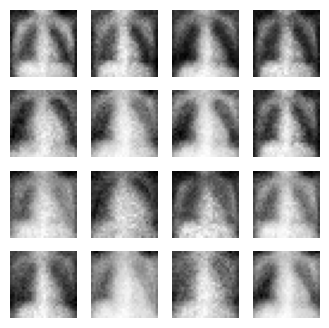

In [ ]:
import matplotlib.pyplot as plt

def save_generated_images(generator, z_dim, num_samples=16):
    generator.eval()
    noise = torch.randn(num_samples, z_dim, device=device)
    fake_images = generator(noise).cpu().detach()
    fake_images = (fake_images + 1) / 2  # Normalize back to [0,1]

    plt.figure(figsize=(4,4))
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        # Selecting the first channel and squeezing to get a 2D array
        plt.imshow(fake_images[i, 0].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

# Generate and save images
save_generated_images(generator, z_dim)

WGAN GP

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MedMNIST dataset
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = PneumoniaMNIST(split="train", transform=data_transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 4.17M/4.17M [00:01<00:00, 3.38MB/s]


In [ ]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, 128 * 7 * 7)
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 128, 7, 7)
        return self.conv_layers(x)

In [ ]:
# Define Critic (instead of Discriminator)
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Initialize model, optimizers
z_dim = 100
generator = Generator(z_dim).to(device)
critic = Critic().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_C = optim.Adam(critic.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
# Gradient Penalty Function
def gradient_penalty(critic, real_images, fake_images):
    alpha = torch.rand(real_images.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
    interpolates_pred = critic(interpolates)

    gradients = torch.autograd.grad(outputs=interpolates_pred, inputs=interpolates,
                                    grad_outputs=torch.ones_like(interpolates_pred),
                                    create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(gradients.shape[0], -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

In [ ]:
# Training Loop
num_epochs = 50
lambda_gp = 10  # Weight for gradient penalty

for epoch in range(num_epochs):
    for real_images, _ in train_loader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Critic
        for _ in range(5):  # Train critic multiple times per generator update
            noise = torch.randn(batch_size, z_dim, device=device)
            fake_images = generator(noise)

            critic_real = critic(real_images)
            critic_fake = critic(fake_images.detach())

            gp = gradient_penalty(critic, real_images, fake_images)
            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp * gp

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

        # Train Generator
        noise = torch.randn(batch_size, z_dim, device=device)
        fake_images = generator(noise)
        loss_G = -torch.mean(critic(fake_images))

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss Critic: {loss_C.item():.4f} | Loss Generator: {loss_G.item():.4f}")

Epoch [1/50] | Loss Critic: -253.4243 | Loss Generator: 13.1321
Epoch [2/50] | Loss Critic: -595.4956 | Loss Generator: 12.6373
Epoch [3/50] | Loss Critic: -1028.7596 | Loss Generator: 9.6705
Epoch [4/50] | Loss Critic: -1390.4923 | Loss Generator: 15.6995
Epoch [5/50] | Loss Critic: -1836.1849 | Loss Generator: 11.9236
Epoch [6/50] | Loss Critic: -2183.5437 | Loss Generator: 3.0245
Epoch [7/50] | Loss Critic: -2393.6326 | Loss Generator: -12.3585
Epoch [8/50] | Loss Critic: -2608.8989 | Loss Generator: -43.6437
Epoch [9/50] | Loss Critic: -2280.5547 | Loss Generator: -85.6178
Epoch [10/50] | Loss Critic: -1280.8221 | Loss Generator: -172.4570
Epoch [11/50] | Loss Critic: -1547.0981 | Loss Generator: -162.8561
Epoch [12/50] | Loss Critic: -1790.4178 | Loss Generator: -139.9388
Epoch [13/50] | Loss Critic: -1493.7357 | Loss Generator: -149.0026
Epoch [14/50] | Loss Critic: 212.4846 | Loss Generator: -176.8563
Epoch [15/50] | Loss Critic: 10355.0635 | Loss Generator: -173.8436
Epoch [16/

In [ ]:
import torch.nn.functional as F

def evaluate_wgan_gp(generator, z_dim, num_samples=100):
    generator.eval()
    fake_images = []

    with torch.no_grad():
        for _ in range(num_samples // 64):
            noise = torch.randn(64, z_dim, device=device)
            generated_batch = generator(noise).cpu()  # Move to CPU
            generated_batch = ((generated_batch + 1) * 127.5).clamp(0, 255).byte()  # Convert to uint8

            # Convert 1-channel grayscale to 3-channel RGB for Inception Model
            generated_batch = generated_batch.repeat(1, 3, 1, 1)

            fake_images.append(generated_batch)

    fake_images = torch.cat(fake_images, dim=0)

    # Inception Score
    is_metric = InceptionScore()
    is_score = is_metric(fake_images)

    # FID Score
    fid_metric = FrechetInceptionDistance(normalize=True)

    real_images, _ = next(iter(train_loader))
    real_images = real_images[:num_samples].cpu()
    real_images = ((real_images + 1) * 127.5).clamp(0, 255).byte()

    # Convert real images to 3-channel RGB
    real_images = real_images.repeat(1, 3, 1, 1)

    fid_metric.update(real_images, real=True)
    fid_metric.update(fake_images, real=False)
    fid_value = fid_metric.compute()

    print(f"Inception Score (IS): {is_score[0].item():.4f} ± {is_score[1].item():.4f}")
    print(f"Fréchet Inception Distance (FID): {fid_value.item():.4f}")

# Run evaluation
evaluate_wgan_gp(generator, z_dim)

Inception Score (IS): 1.5046 ± 0.2318
Fréchet Inception Distance (FID): 217.0957


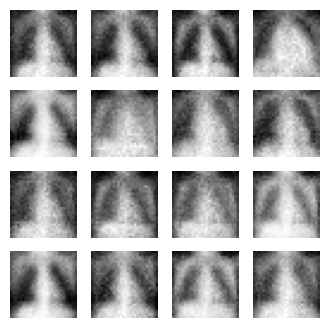

In [ ]:
import matplotlib.pyplot as plt

def save_generated_images(generator, z_dim, num_samples=16):
    generator.eval()
    noise = torch.randn(num_samples, z_dim, device=device)
    fake_images = generator(noise).cpu().detach()
    fake_images = (fake_images + 1) / 2  # Normalize back to [0,1]

    plt.figure(figsize=(4,4))
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        # Selecting the first channel and squeezing to get a 2D array
        plt.imshow(fake_images[i, 0].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

# Generate and save images
save_generated_images(generator, z_dim)

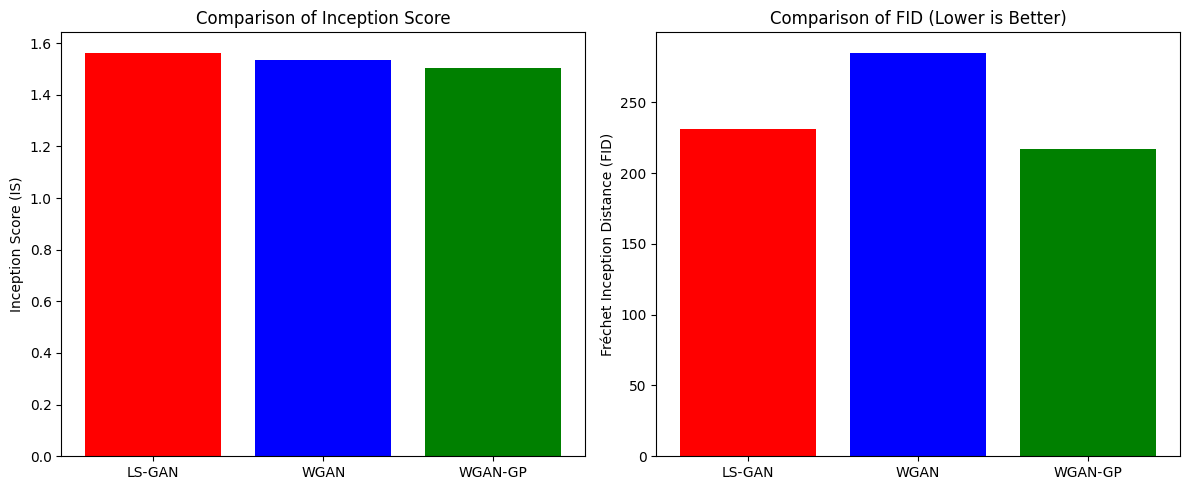

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example Scores (Replace with actual values after evaluation)
gan_models = ["LS-GAN", "WGAN", "WGAN-GP"]
inception_scores = [1.5637,1.5339 ,1.5046 ]  # Replace with actual IS scores
fid_scores = [231.3327, 285.1017,217.0957]    # Replace with actual FID scores

# Bar Plot for Inception Score (IS)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(gan_models, inception_scores, color=['red', 'blue', 'green'])
plt.ylabel("Inception Score (IS)")
plt.title("Comparison of Inception Score")

# Bar Plot for Fréchet Inception Distance (FID)
plt.subplot(1, 2, 2)
plt.bar(gan_models, fid_scores, color=['red', 'blue', 'green'])
plt.ylabel("Fréchet Inception Distance (FID)")
plt.title("Comparison of FID (Lower is Better)")

plt.tight_layout()
plt.show()